## Lecture 7: Introduction to Geospatial analysis using Python tools
### Author: Nadiia Gorash, UBDC Data Scientist

### GeoPandas

[GeoPandas](http://geopandas.org/) is an open source project to make working with geospatial data in python easier. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by [shapely](https://shapely.readthedocs.io/en/stable/) and [fiona](https://fiona.readthedocs.io/en/latest/manual.html). 


The main data structures in geopandas are `GeoSeries` and `GeoDataFrame` which extend the capabilities of `Series` and `DataFrames` from pandas.

The main difference between geodataframes and pandas dataframes is that a [geodataframe](http://geopandas.org/data_structures.html#geodataframe) contains a column to store geometries. By default, the name of this column is `'geometry'`. 

### Data

The data used in this lab is collected from http://www.adzuna.co.uk/ using [***Adzuna API***](https://developer.adzuna.com/) for UK. 

The data has been subselected to `location_area_1` containing `Scotland` value. 

In [1]:
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
import contextily as ctx

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon

import geoplot
import mapclassify as mc

In [2]:
source= '../data/adzuna_scotland.parquet'

In [3]:
#open dataset stored in parquet format
df = pq.read_table(source=source).to_pandas()

In [4]:
df.head()

,salary_min,contract_time,company_display_name,category_label,category_tag,salary_is_predicted,title,id,description,created,...,location_area_0,location_area_1,location_area_2,contract_type,longitude,latitude,location_area_3,location_area_4,location_area_5,scraped_date
86,26480.77,full_time,Boots,Healthcare & Nursing Jobs,healthcare-nursing-jobs,1,Relief Pharmacist – Greater Glasgow,1610439635,Need to know We are looking for a fantastic Ph...,2020-07-21T08:37:58Z,...,UK,Scotland,West Dunbartonshire,None,-4.550980,55.949402,Dumbarton,None,None,21072020
385,16742.00,None,The Best Connection,Logistics & Warehouse Jobs,logistics-warehouse-jobs,0,Mill Operative,1596834392,"We are recruiting for hard working, reliable a...",2020-07-08T06:09:13Z,...,UK,Scotland,Dumfries & Galloway,contract,-3.355940,55.120201,Lockerbie,None,None,21072020
514,17928.62,full_time,Morrisons,Part time Jobs,part-time-jobs,1,SUPPORT PHARMACIST - COWDENBEATH (PART TIME),1610442709,We&rsquo;ve got a fantastic opportunity for a ...,2020-07-21T08:39:32Z,...,UK,Scotland,Fife,None,-3.343290,56.110199,Cowdenbeath,None,None,21072020
850,37047.00,full_time,South Ayrshire,Social work Jobs,social-work-jobs,0,Social Worker (Children & Families) - Whitlett...,1610804167,Job Description What is the role? To promote a...,2020-07-21T14:41:13Z,...,UK,Scotland,South Ayrshire,permanent,-4.607136,55.469722,Ayr,Ayr Central,None,21072020
1030,31800.00,None,NHS National Services Scotland,Healthcare & Nursing Jobs,healthcare-nursing-jobs,0,Midwife - Direct Care - Gracemount Medical Centre,1608261071,NHS Lothian is committed to encouraging equali...,2020-07-18T13:20:27Z,...,UK,Scotland,Midlothian,permanent,-3.202320,55.858501,Penicuik,Milton Bridge,Edinburgh Technopole,21072020


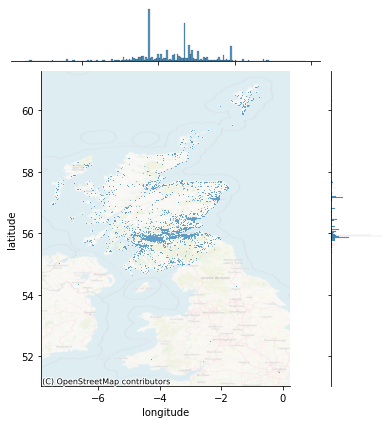

In [7]:
##let's look at the data using seaborn library

# Generate scatter plot
# change for different base map
# https://contextily.readthedocs.io/en/latest/providers_deepdive.html

df_plot = sns.jointplot(x='longitude', y='latitude', data=df, s=0.7);
ctx.add_basemap(df_plot.ax_joint, crs="EPSG:4326",
    source=ctx.providers.OpenStreetMap.Mapnik, alpha = 0.4
);


We are going to convert `DataFrame` into `GeoDataframe` to be able to perform geospatial analysis.

The convention is to `import geopandas as gpd`

GeoPandas is an open source project to make working with geospatial data in python easier. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by [shapely](https://shapely.readthedocs.io/en/stable/). Geopandas further depends on fiona for file access and descartes and matplotlib for plotting.

 `geopandas.GeoDataFrame(*args, **kwargs)`
A GeoDataFrame object is a pandas.DataFrame that has a column with *geometry*


`geopandas.points_from_xy(x, y, z=None, crs=None) `  Generate `GeometryArray` of shapely Point geometries from x, y(, z) coordinates.

In [8]:
#creating geodataframe

gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))

In [9]:
gdf.head()

,salary_min,contract_time,company_display_name,category_label,category_tag,salary_is_predicted,title,id,description,created,...,location_area_1,location_area_2,contract_type,longitude,latitude,location_area_3,location_area_4,location_area_5,scraped_date,geometry
86,26480.77,full_time,Boots,Healthcare & Nursing Jobs,healthcare-nursing-jobs,1,Relief Pharmacist – Greater Glasgow,1610439635,Need to know We are looking for a fantastic Ph...,2020-07-21T08:37:58Z,...,Scotland,West Dunbartonshire,None,-4.550980,55.949402,Dumbarton,None,None,21072020,POINT (-4.55098 55.94940)
385,16742.00,None,The Best Connection,Logistics & Warehouse Jobs,logistics-warehouse-jobs,0,Mill Operative,1596834392,"We are recruiting for hard working, reliable a...",2020-07-08T06:09:13Z,...,Scotland,Dumfries & Galloway,contract,-3.355940,55.120201,Lockerbie,None,None,21072020,POINT (-3.35594 55.12020)
514,17928.62,full_time,Morrisons,Part time Jobs,part-time-jobs,1,SUPPORT PHARMACIST - COWDENBEATH (PART TIME),1610442709,We&rsquo;ve got a fantastic opportunity for a ...,2020-07-21T08:39:32Z,...,Scotland,Fife,None,-3.343290,56.110199,Cowdenbeath,None,None,21072020,POINT (-3.34329 56.11020)
850,37047.00,full_time,South Ayrshire,Social work Jobs,social-work-jobs,0,Social Worker (Children & Families) - Whitlett...,1610804167,Job Description What is the role? To promote a...,2020-07-21T14:41:13Z,...,Scotland,South Ayrshire,permanent,-4.607136,55.469722,Ayr,Ayr Central,None,21072020,POINT (-4.60714 55.46972)
1030,31800.00,None,NHS National Services Scotland,Healthcare & Nursing Jobs,healthcare-nursing-jobs,0,Midwife - Direct Care - Gracemount Medical Centre,1608261071,NHS Lothian is committed to encouraging equali...,2020-07-18T13:20:27Z,...,Scotland,Midlothian,permanent,-3.202320,55.858501,Penicuik,Milton Bridge,Edinburgh Technopole,21072020,POINT (-3.20232 55.85850)


In [10]:
print(gdf.crs)

None


### Map Projections and CRS

Map projections try to portray the surface of the earth, or a portion of the earth, on a flat piece of paper or computer screen. In layman’s term, map projections try to transform the earth from its spherical shape (3D) to a planar shape (2D).

A coordinate reference system (CRS) then defines how the two-dimensional, projected map in your GIS relates to real places on the earth. The decision of which map projection and CRS to use depends on the regional extent of the area you want to work in, on the analysis you want to do, and often on the availability of data. [Source](https://docs.qgis.org/3.16/en/docs/gentle_gis_introduction/coordinate_reference_systems.html#)

![Distortions of the surface using different projections](../images/map_projections.png)
[Source](http://bl.ocks.org/vlandham/raw/9216751/)

Another example

![Another Example](../images/sinucyli-animation.gif)

[Source](https://blog.map-projections.net/the-sinucyli-projection)

We are going to set coordinates to WGS84 (lon/lat) using `set_crs` and a EPSG (European Petroleum Survey Group) code  `epsg` of the coornate system. 

In [11]:
gdf.set_crs(epsg=4326, inplace=True)
print(gdf.crs)

epsg:4326


**More about CRS**  

- https://spatialreference.org/ref/epsg/ 
- https://proj.org/operations/projections/

### Visualisation

Let's visualise and  explore the  data on the map. Geopandas  uses matplotlib library for plotting data. Similarly to plotting `DataFrame`, to create a baic map from a `GeoDataFrame`  use ``.plot()``

**This function in GeoPandas creates a map based on the geometry columna**. 


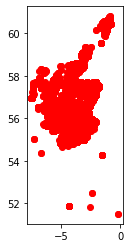

In [12]:
# plot the GeoDataFrame
gdf.plot( color='red')

plt.show()

### Open different file formats of spatial data

We are going to load boundary of Scotland to remove outliers using free OS data [BoundaryLine](https://www.ordnancesurvey.co.uk/business-government/products/boundaryline)


Geopandas can read almost any vector-based spatial data format including ESRI shapefile, GeoJSON files and more using the command `geopandas.read_file()`  which returns a GeoDataFrame object.
[More info](https://geopandas.org/io.html)

In [13]:
os_data=gpd.read_file('../data/district_borough_unitary.shp')

#if loading full dataset use this: 
#os_data = gpd.read_file("bdline_gb.gpkg", layer='bdline_gb district_borough_unitary')

In [14]:
#check the CRS
os_data.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

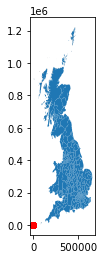

In [15]:
#Visualisation of the data
ax1 = os_data.plot()

## adding both datasets together
gdf.plot( color='red',ax = ax1)

plt.show()

Firstly, let's make the plot bigger and fix projection issue using [`to_crs`]( https://geopandas.org/reference.html#geopandas.GeoDataFrame.to_crs)

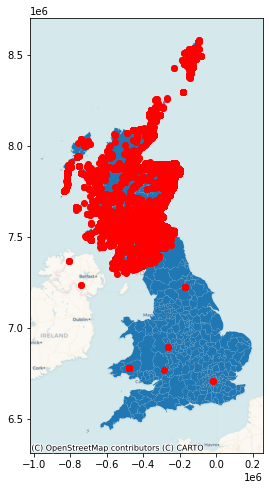

In [16]:
fig, ax = plt.subplots(figsize=(12,8))

#Reprojecting to align with background mapping,hence using webmerkator
os_data = os_data.to_crs(epsg= 3857)

# Plot the data
os_data.plot(ax=ax)
gdf.to_crs(epsg = 3857).plot(color = 'red',ax=ax)
# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)

**N.B.** both layers could have been projected to the same projection and then the same projection code could have been added to contextily as a parameter


```python
fig, ax = plt.subplots(figsize=(12,8)) 
#Plot the data
os_data.to_crs(epsg =4326).plot(ax=ax)
gdf.plot(color = 'red',ax=ax)
#Add basemap
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.CartoDB.Voyager)
```
expected output
![image](../images/ctx_4326_expected_output.png)

Full list of available backgrounds

```python
ctx.providers.keys()
```

<span style="font-family:Courier New"><span style="color:gray">'OpenStreetMap', 'OpenSeaMap', 'OpenPtMap', 'OpenTopoMap', 'OpenRailwayMap', 'OpenFireMap', 'SafeCast', 'Thunderforest', 'OpenMapSurfer', 'Hydda', 'MapBox', 'Stamen', 'Esri', 'OpenWeatherMap', 'HERE', 'FreeMapSK', 'MtbMap', 'CartoDB', 'HikeBike', 'BasemapAT', 'nlmaps', 'NASAGIBS', 'NLS', 'JusticeMap', 'Wikimedia', 'GeoportailFrance', 'OneMapSG' </span></span>

```python 
ctx.providers.KEYNAME.keys()
```

Example provider **HERE**

<span style="font-family:Courier New"><span style="color:gray">'normalDay', 'normalDayCustom', 'normalDayGrey', 'normalDayMobile', 'normalDayGreyMobile', 'normalDayTransit', 'normalDayTransitMobile', 'normalNight', 'normalNightMobile', 'normalNightGrey', 'normalNightGreyMobile', 'normalNightTransit', 'normalNightTransitMobile', 'reducedDay', 'reducedNight', 'basicMap', 'mapLabels', 'trafficFlow', 'carnavDayGrey', 'hybridDay', 'hybridDayMobile', 'hybridDayTransit', 'hybridDayGrey', 'pedestrianDay', 'pedestrianNight', 'satelliteDay', 'terrainDay', 'terrainDayMobile'</span></span>

### Spatial Join 

[More info](https://geopandas.org/mergingdata.html#spatial-joins)

In [17]:
#removing outliers by selecting only those inside the scotland
os_data.head()

,fid,Name,Area_Code,Area_Descr,File_Name,Feature_Se,Collection,Global_Pol,Admin_Unit,Census_Cod,Hectares,Non_Inland,Area_Type_,Area_Typ_1,Non_Area_T,Non_Area_1,geometry
0,1.0,Barnsley District (B),MTD,Metropolitan District,BARNSLEY_DISTRICT_(B),1,1,50242,9182,E08000016,32907.759,0.0,AA,CIVIL ADMINISTRATION AREA,None,None,"POLYGON ((-200538.815 7072468.726, -200533.754..."
1,2.0,Bolton District (B),MTD,Metropolitan District,BOLTON_DISTRICT_(B),2,2,56602,18832,E08000001,13979.204,0.0,AA,CIVIL ADMINISTRATION AREA,None,None,"POLYGON ((-262089.348 7080937.661, -262092.884..."
2,3.0,Bradford District (B),MTD,Metropolitan District,BRADFORD_DISTRICT_(B),3,3,61045,16726,E08000032,36641.974,0.0,AA,CIVIL ADMINISTRATION AREA,None,None,"POLYGON ((-218154.613 7129405.155, -218171.170..."
3,4.0,Bury District (B),MTD,Metropolitan District,BURY_DISTRICT_(B),4,4,56616,18846,E08000002,9946.013,0.0,AA,CIVIL ADMINISTRATION AREA,None,None,"POLYGON ((-260957.224 7084571.047, -260959.266..."
4,5.0,Calderdale District (B),MTD,Metropolitan District,CALDERDALE_DISTRICT_(B),5,5,61033,16714,E08000033,36396.099,0.0,AA,CIVIL ADMINISTRATION AREA,None,None,"POLYGON ((-226077.293 7100249.158, -226064.175..."


In [18]:
#os_data['Name'].unique()
os_data.groupby(os_data['Census_Cod'].str.get(0))['Census_Cod'].count()

Census_Cod
E    317
S     32
W     22
Name: Census_Cod, dtype: int64

In [19]:
os_data.loc[os_data['Census_Cod'].str.get(0)=='S']['Name'].unique()

array(['Clackmannanshire', 'Dundee City', 'East Dunbartonshire',
       'East Renfrewshire', 'Falkirk', 'Midlothian', 'Scottish Borders',
       'South Lanarkshire', 'Stirling', 'West Dunbartonshire',
       'West Lothian', 'City of Edinburgh', 'East Lothian', 'Angus',
       'East Ayrshire', 'Glasgow City', 'Inverclyde', 'North Lanarkshire',
       'Perth and Kinross', 'Renfrewshire', 'Highland', 'Moray',
       'Orkney Islands', 'Na h-Eileanan an Iar', 'Argyll and Bute',
       'Aberdeenshire', 'Fife', 'Aberdeen City', 'Shetland Islands',
       'North Ayrshire', 'Dumfries and Galloway', 'South Ayrshire'],
      dtype=object)

In [20]:
# Select Glasgow data
glasgow = os_data.loc[os_data['Name']=='Glasgow City']

<AxesSubplot:>

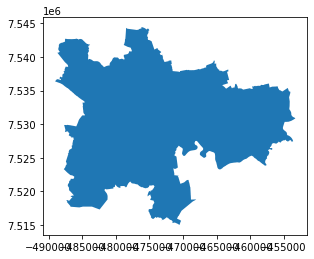

In [21]:
glasgow.plot()

In [22]:
glasgow.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [23]:
# Make a spatial join
#join = gpd.sjoin(gdf, glasgow, how="inner", op="within")

#first get an error then fix
join = gpd.sjoin(gdf,glasgow.to_crs(epsg=4326), how ='inner', op ='within')

/Users/qzhao/opt/anaconda3/envs/lab07/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


<AxesSubplot:>

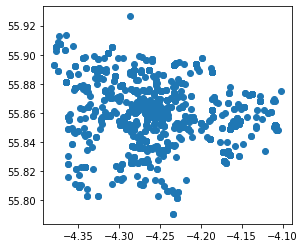

In [24]:
join.plot()

In [25]:
len(join)

3736

In [26]:
#examine what's inside

join.head()

,salary_min,contract_time,company_display_name,category_label,category_tag,salary_is_predicted,title,id,description,created,...,Collection,Global_Pol,Admin_Unit,Census_Cod,Hectares,Non_Inland,Area_Type_,Area_Typ_1,Non_Area_T,Non_Area_1
22709,34866.10,None,Ashurst,IT Jobs,it-jobs,1,Data Analyst,1610942278,About Ashurst: Ashurst is a leading global law...,2020-07-21T17:18:08Z,...,105,81237,30631,S12000049,17635.598,173.468,AA,CIVIL ADMINISTRATION AREA,None,None
28484,26121.94,None,Dentons,Legal Jobs,legal-jobs,1,"Contract Analyst (Paralegal), Commercial - Gla...",1610942368,Purpose of role An exciting opportunity has ar...,2020-07-21T17:18:19Z,...,105,81237,30631,S12000049,17635.598,173.468,AA,CIVIL ADMINISTRATION AREA,None,None
61760,54337.07,None,RX+ Medical,Healthcare & Nursing Jobs,healthcare-nursing-jobs,1,ST3 - General Medical (Non-Cons),1588810059,RX Medical is seeking a qualified doctor to fi...,2020-06-30T15:56:10Z,...,105,81237,30631,S12000049,17635.598,173.468,AA,CIVIL ADMINISTRATION AREA,None,None
76322,15763.00,full_time,Search Consultancy LTD,Customer Services Jobs,customer-services-jobs,0,Customer Service Advisor,1603084362,Inbound customer service advisor Hours availab...,2020-07-14T12:11:09Z,...,105,81237,30631,S12000049,17635.598,173.468,AA,CIVIL ADMINISTRATION AREA,None,None
84629,71701.62,None,MORGAN STANLEY,IT Jobs,it-jobs,1,Cyber Security Response Manager,1612006355,Job Description - Cyber Security Response Mana...,2020-07-22T15:35:15Z,...,105,81237,30631,S12000049,17635.598,173.468,AA,CIVIL ADMINISTRATION AREA,None,None


In [27]:
# demo that GeoDataFrame could be manipulated as DataFrame
#most popular category of jobs
join.groupby('category_label')['salary_min'].mean().reset_index().sort_values(by='salary_min')

,category_label,salary_min
12,Hospitality & Catering Jobs,13897.645323
28,Travel Jobs,14973.143871
5,Customer Services Jobs,17078.804211
20,Part time Jobs,17105.807903
6,Domestic help & Cleaning Jobs,17333.991642
25,Social work Jobs,19498.079889
15,Logistics & Warehouse Jobs,19714.071587
17,Manufacturing Jobs,19759.344074
26,Teaching Jobs,21184.034659
22,Retail Jobs,21794.325500


In [28]:
join.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### geoplot : geospatial data viz
[geoplot](https://residentmario.github.io/geoplot/index.html)

/Users/qzhao/opt/anaconda3/envs/lab07/lib/python3.7/site-packages/geoplot/crs.py:80: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  return getattr(ccrs, self.__class__.__name__)(**{**centerings, **self.args})


<GeoAxesSubplot:>

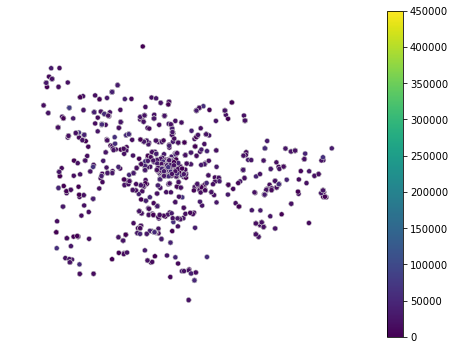

In [29]:
geoplot.pointplot(
    join, projection=geoplot.crs.OSGB(),
    hue='salary_min',
    legend=True, 
    edgecolor='lightgray', linewidth=0.5
)

[**mapclassify**](https://pysal.org/notebooks/viz/mapclassify/intro.html)  to classify data and aplly classification schemes for Choropleth Maps 

In [30]:
scheme = mc.Quantiles(join['salary_min'])

<GeoAxesSubplot:>

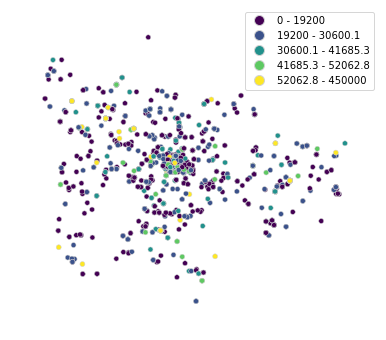

In [31]:
geoplot.pointplot(
    join, projection=geoplot.crs.OSGB(),
    hue='salary_min',
    legend=True,
    edgecolor='lightgray', linewidth=0.5, scheme=scheme
)

### Clip

`geopandas.clip(gdf, mask, keep_geom_type=False)`
Clip points, lines, or polygon geometries to the mask extent.

Both layers must be in the same Coordinate Reference System (CRS). The gdf will be clipped to the full extent of the clip object.

If there are multiple polygons in mask, data from gdf will be clipped to the total boundary of all polygons in mask.

In [32]:
print(glasgow.crs)
print(gdf.crs)

epsg:3857
epsg:4326


In [33]:
#Let's reproject both layers to BNG

gdf.to_crs(epsg=3857,inplace =True)
glasgow.to_crs(epsg = 3857,inplace=True)

/Users/qzhao/opt/anaconda3/envs/lab07/lib/python3.7/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [34]:
clipped = gpd.clip(gdf, glasgow)

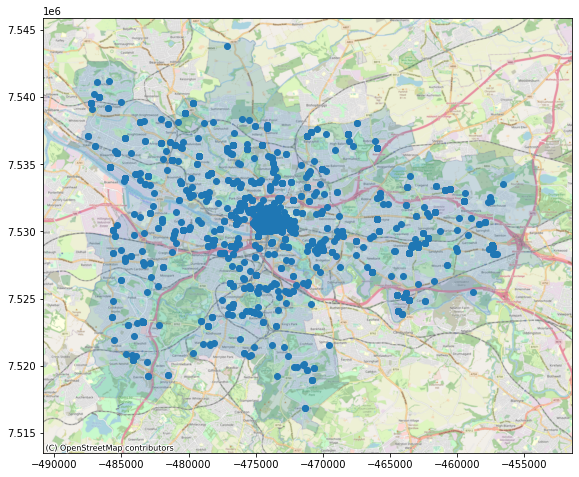

In [35]:
fig, ax1 = plt.subplots(figsize=(12,8))
# Plot the data
clipped.plot(ax=ax1)
glasgow.plot(ax=ax1,alpha=0.2 )
# Add basemap
ctx.add_basemap(ax1, source=ctx.providers.OpenStreetMap.Mapnik)

In [36]:
print(len(clipped))

3736


In [37]:
assert len(clipped) == len(join)

In [38]:
clipped.head()

,salary_min,contract_time,company_display_name,category_label,category_tag,salary_is_predicted,title,id,description,created,...,location_area_1,location_area_2,contract_type,longitude,latitude,location_area_3,location_area_4,location_area_5,scraped_date,geometry
7219066,18816.0,full_time,HC One Ltd,Social work Jobs,social-work-jobs,0,Senior Care Assistant,1771654833,About The Role Night Shift Position Calling al...,2020-10-19T17:59:32Z,...,Scotland,East Dunbartonshire,permanent,-4.205424,55.893359,Bishopbriggs,None,None,20102020,POINT (-468145.658 7537215.673)
1598459,17856.0,full_time,HC One Ltd,Social work Jobs,social-work-jobs,0,Care Assistant,1642945234,About The Role Days and Night Shifts Available...,2020-08-14T17:20:54Z,...,Scotland,East Dunbartonshire,permanent,-4.205424,55.893359,Bishopbriggs,None,None,17082020,POINT (-468145.658 7537215.673)
5241746,18816.0,full_time,HC One Ltd,Social work Jobs,social-work-jobs,0,Senior Care Assistant,1726890273,About The Role Night Shift Position Calling al...,2020-09-26T18:41:22Z,...,Scotland,East Dunbartonshire,permanent,-4.205424,55.893359,Bishopbriggs,None,None,29092020,POINT (-468145.658 7537215.673)
33439361,35520.0,full_time,HC One Ltd,Healthcare & Nursing Jobs,healthcare-nursing-jobs,0,Deputy Home Manager,1583075577,About The Role £1000 Welcome Bonus. Paid NMC P...,2020-06-24T13:19:06Z,...,Scotland,East Dunbartonshire,permanent,-4.205424,55.893359,Bishopbriggs,None,None,14072020,POINT (-468145.658 7537215.673)
33704758,21120.0,full_time,HC One Ltd,Healthcare & Nursing Jobs,healthcare-nursing-jobs,0,Registered/Pre Registered Nurses,1608951147,About The Role Registered/Pre Registered Nurse...,2020-07-19T12:44:54Z,...,Scotland,East Dunbartonshire,permanent,-4.205424,55.893359,Bishopbriggs,None,None,21072020,POINT (-468145.658 7537215.673)


The extent of a plot is the span of its axes. In `geoplot` it is formatted as a tuple of (_min_longitude, min_latitude, max_longitude, max_latitude_). 

For example, a plot covering the entire world would have a span of (-180, -180, 180, 180).

In [39]:
clipped_wgs84 = clipped.to_crs(epsg = 4326)
#clipped_bng.head()

<AxesSubplot:>

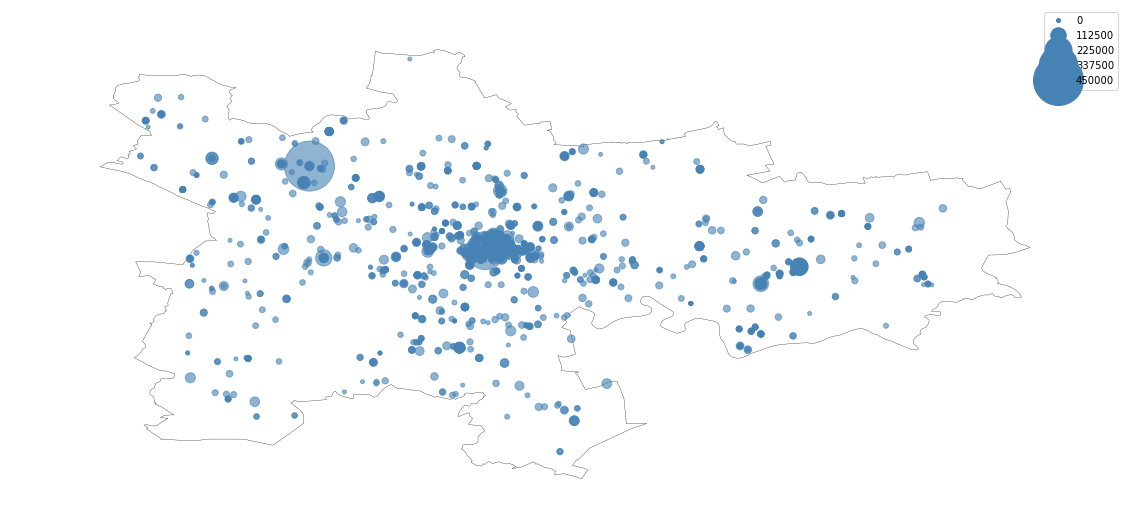

In [40]:
ax = geoplot.pointplot(
    clipped_wgs84, 
    scale='salary_min', limits=(4, 50),
    figsize=(20,12), alpha = 0.6, legend = True
)
geoplot.polyplot(glasgow.to_crs(epsg=4326), linewidth=0.3,ax=ax)

## Tranformation between GeoDataFrame and DataFrame


Data used is [DataZone boundaries](https://data.gov.uk/dataset/ab9f1f20-3b7f-4efa-9bd2-239acf63b540/data-zone-boundaries-2011) which was converted to geojson and clipped for Glasgow for this exercise.

In [41]:
#opening dz

dz=gpd.read_file('../data/dz_glasgow.geojson')

In [42]:
dz.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [43]:
gdf.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [44]:
gdf.to_crs(epsg=27700,inplace = True)

In [45]:
gdf.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

<AxesSubplot:>

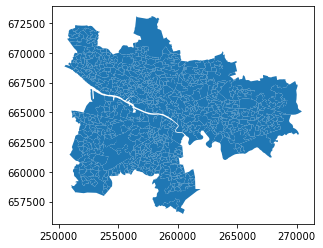

In [46]:
dz.plot()

In [47]:
# Make a spatial join
dz_join = gpd.sjoin(gdf, dz, op="within")

/Users/qzhao/opt/anaconda3/envs/lab07/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [48]:
dz_join.head()

,salary_min,contract_time,company_display_name,category_label,category_tag,salary_is_predicted,title,id,description,created,...,DataZone,Name,TotPop2011,ResPop2011,HHCnt2011,StdAreaHa,StdAreaKm2,Shape_Leng,Shape_Area,city_name
22709,34866.10,None,Ashurst,IT Jobs,it-jobs,1,Data Analyst,1610942278,About Ashurst: Ashurst is a leading global law...,2020-07-21T17:18:08Z,...,S01010136,Greenfield - 06,809,809,367,20.636802,0.206367,2796.584478,206368.021032,Glasgow
28484,26121.94,None,Dentons,Legal Jobs,legal-jobs,1,"Contract Analyst (Paralegal), Commercial - Gla...",1610942368,Purpose of role An exciting opportunity has ar...,2020-07-21T17:18:19Z,...,S01010136,Greenfield - 06,809,809,367,20.636802,0.206367,2796.584478,206368.021032,Glasgow
98648,45000.00,None,NetTalent,IT Jobs,it-jobs,0,Network Engineer,1614535394,"Network Engineer Permanent Glasgow Circa £45,0...",2020-07-24T20:35:07Z,...,S01010136,Greenfield - 06,809,809,367,20.636802,0.206367,2796.584478,206368.021032,Glasgow
154518,36886.99,None,McGregor Boyall,IT Jobs,it-jobs,1,C# .NET Developer,1588059613,"Our client is reaching out for passionate, dri...",2020-06-29T20:27:45Z,...,S01010136,Greenfield - 06,809,809,367,20.636802,0.206367,2796.584478,206368.021032,Glasgow
222212,28000.00,None,Cathcart Associates Limited,IT Jobs,it-jobs,0,Software Developer,1612472184,Award winning Software House that create marke...,2020-07-23T01:52:51Z,...,S01010136,Greenfield - 06,809,809,367,20.636802,0.206367,2796.584478,206368.021032,Glasgow


In [49]:
salaries = dz_join.groupby('Name')['salary_min'].mean().reset_index()

In [50]:
salaries.head()

,Name,salary_min
0,Alexandra Parade - 02,31290.4300
1,Anderston - 01,36589.3325
2,Anderston - 02,21946.6900
3,Anderston - 04,61590.0000
4,Anderston - 05,24913.9100


> ? What changed? 

In [51]:
salaries.rename(columns={'salary_min':'salary_mean'},inplace= True)

In [52]:
salaries_dz = pd.merge(salaries, dz, on='Name')

In [53]:
salaries_dz.head()

,Name,salary_mean,DataZone,TotPop2011,ResPop2011,HHCnt2011,StdAreaHa,StdAreaKm2,Shape_Leng,Shape_Area,city_name,geometry
0,Alexandra Parade - 02,31290.4300,S01010240,691,691,398,4.092162,0.040921,977.399344,40921.623800,Glasgow,"MULTIPOLYGON (((261786.235 665684.179, 261767...."
1,Anderston - 01,36589.3325,S01010276,993,993,625,24.092175,0.240921,2584.611012,240921.717787,Glasgow,"MULTIPOLYGON (((257546.000 665352.000, 257618...."
2,Anderston - 02,21946.6900,S01010277,610,610,305,11.881241,0.118813,2423.454624,118812.417480,Glasgow,"MULTIPOLYGON (((257659.999 665609.999, 257662...."
3,Anderston - 04,61590.0000,S01010279,605,605,312,4.895779,0.048958,2208.696592,48957.781355,Glasgow,"MULTIPOLYGON (((257304.733 665774.109, 257237...."
4,Anderston - 05,24913.9100,S01010280,783,782,426,9.580797,0.095807,2072.370863,95807.966249,Glasgow,"MULTIPOLYGON (((257959.000 666014.000, 257958...."


In [54]:
type(salaries_dz)

pandas.core.frame.DataFrame

In [55]:
salaries_dz_gdf = gpd.GeoDataFrame(salaries_dz,geometry = 'geometry')

<AxesSubplot:>

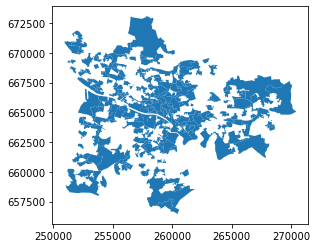

In [56]:
salaries_dz_gdf.plot()

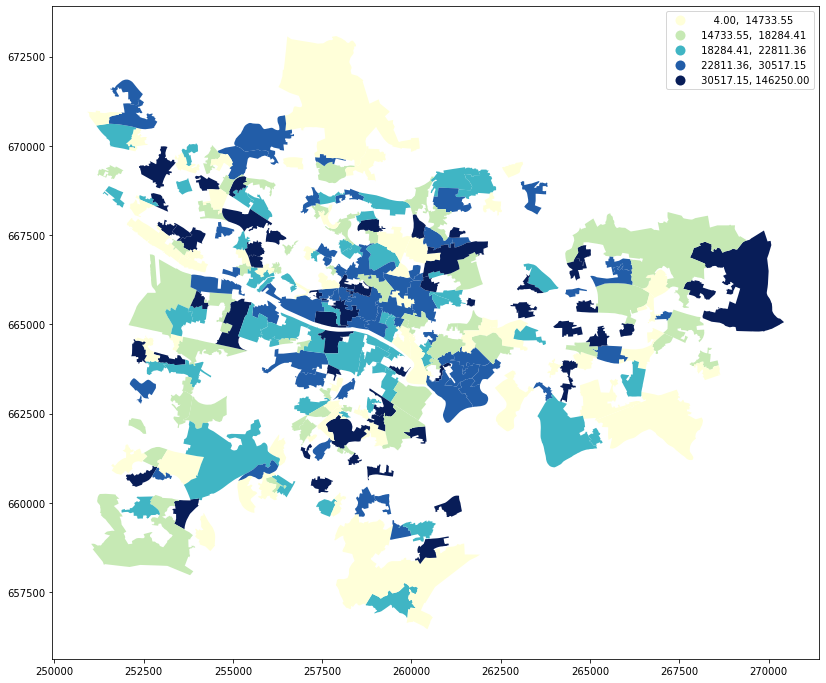

In [57]:
salaries_dz_gdf.plot(column='salary_mean', cmap =    
                                'YlGnBu', figsize=(20,12),   
                                 scheme='quantiles', k=5, legend =  
                                  True);

[Colourmaps](https://matplotlib.org/tutorials/colors/colormaps.html)

/Users/qzhao/opt/anaconda3/envs/lab07/lib/python3.7/site-packages/geoplot/geoplot.py:1267: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in scaled_polygon:
/Users/qzhao/opt/anaconda3/envs/lab07/lib/python3.7/site-packages/geoplot/geoplot.py:903: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


<AxesSubplot:>

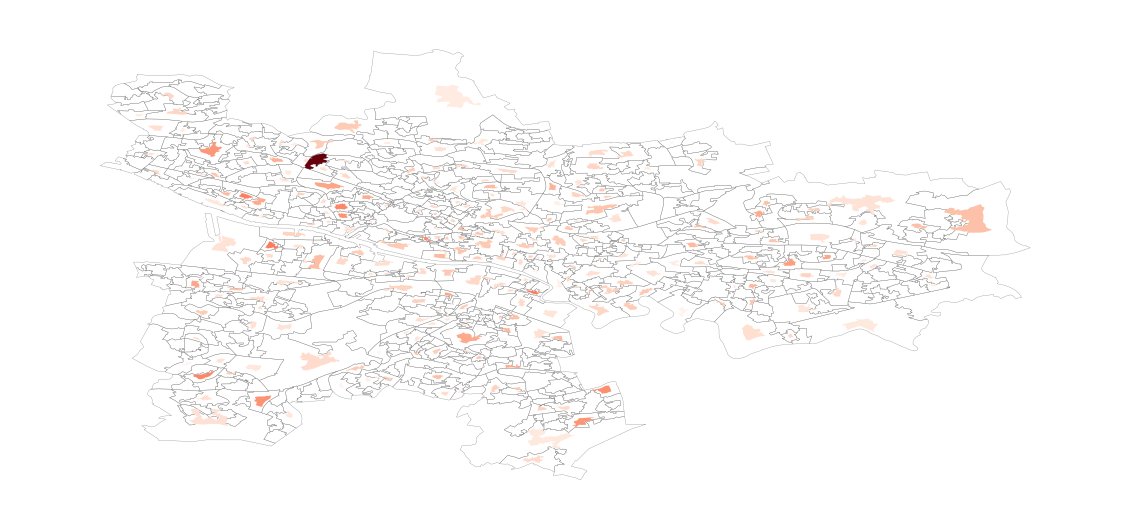

In [58]:
ax2 = geoplot.cartogram(
    salaries_dz_gdf.to_crs(epsg=4326), scale='salary_mean',
    edgecolor='None', hue='salary_mean', cmap='Reds',
    figsize=(20, 12)
)

geoplot.polyplot(dz.to_crs(epsg=4326), edgecolor='grey',linewidth = 0.3, zorder=0, ax=ax2)

### Data export

`GeoDataFrame.to_file(self, filename, driver='ESRI Shapefile', schema=None, index=None, **kwargs)`

Write the GeoDataFrame to a file. By default, an ESRI shapefile is written, but any OGR data source supported by Fiona can be written.


>GeoDataFrame can contain more field types than supported by most of the file formats. For example tuples or lists can be easily stored in the GeoDataFrame, but saving them to e.g. GeoPackage or Shapefile will raise a ValueError. Before saving to a file, they need to be converted to a format supported by a selected driver.

 [More info about data outputs](https://geopandas.org/io.html)

In [58]:
clipped.to_file("adzuna_glasgow.shp")